In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy

# how to change this from fooof (1.x.x) to specparam (2.0.0)
from fooof import FOOOFGroup
from fooof.sim.gen import gen_aperiodic

from model import create_model
from scipy.stats import linregress
from scipy.signal import decimate

--No graphics will be displayed.


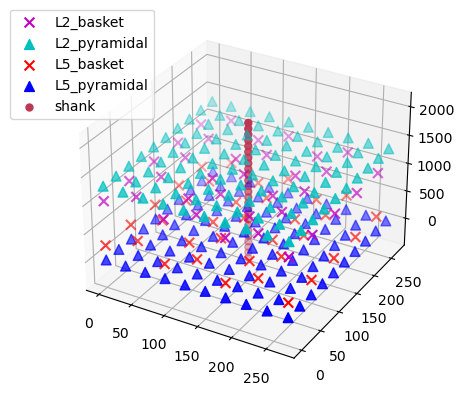

In [2]:
n_trials = 100
n_electrodes = 25

# @Carolina, how to change the colors and shapes of the neurons and electrodes?
net_ds = create_model()
_ = net_ds.plot_cells()

In [3]:
# load and downsample model LFPs
srate_orig = 40000
srate = 2000
dwnsmpl_fctr = int(srate_orig / srate)

ds_trial_signals = np.load('shank_ds.npy')
us_trial_signals = np.load('shank_us.npy')
print(np.shape(ds_trial_signals))

ds_trial_signals = decimate(ds_trial_signals, dwnsmpl_fctr, n=None, ftype='fir', axis=-1)
us_trial_signals = decimate(us_trial_signals, dwnsmpl_fctr, n=None, ftype='fir', axis=-1)
print(np.shape(ds_trial_signals))

(100, 25, 18001)
(100, 25, 901)


In [4]:
winsize = 128
overlap = int(winsize * 7 / 8)
fft_length = int(winsize * 16)
freq_lims = [0.5, 250]

## Compute power spectra over whole trial, then split

In [5]:
def get_psd_means(trial_signals):
    
    # Compute power spectral density from STFT 
    freqs, times, Zxx = scipy.signal.stft(trial_signals, fs=srate, window='hann', nperseg=winsize,
                                          noverlap=overlap, nfft=fft_length, detrend='constant',
                                          return_onesided=True, boundary='zeros', padded=True, axis=-1)
    # compute power
    layer_psd = np.abs(Zxx) ** 2

    f_idx = (freqs >= freq_lims[0]) & (freqs < freq_lims[1])
    freqs = freqs[f_idx]

    # freq range
    layer_psd = layer_psd[:, :, f_idx, :]

    # split
    layer_psd_before = layer_psd[:, :, :, times <= 0.128]
    layer_psd_after = layer_psd[:, :, :, times >= 0.128]
   
    # compute means
    layer_psd_before_mean = np.mean(layer_psd_before, axis=-1)
    layer_psd_after_mean = np.mean(layer_psd_after, axis=-1)
    
    return layer_psd_before_mean, layer_psd_after_mean, freqs

# detected
mds_layer_psd_before, mds_layer_psd_after, ds_freqs = get_psd_means(ds_trial_signals)
# undetected
mus_layer_psd_before, mus_layer_psd_after, us_freqs = get_psd_means(us_trial_signals)

**Parameterize power spectra**

In [6]:
def parameterize_spectra(layer_psd_mean, freqs):
    
    layer_offsets = np.zeros((n_trials, n_electrodes))
    layer_slopes = np.zeros((n_trials, n_electrodes))
    layer_aperiodic = np.zeros((n_trials, n_electrodes, len(freqs)))
    
    for t in range(layer_psd_mean.shape[0]):
        trial_psd = layer_psd_mean[t, :, :]

        fg = FOOOFGroup()
        fg.fit(freqs, trial_psd, freq_lims)
        for i in range(trial_psd.shape[0]):
            layer_offsets[t, i] = fg[i].aperiodic_params[0]
            layer_slopes[t, i] = fg[i].aperiodic_params[1]
            layer_aperiodic[t, i, :] = gen_aperiodic(freqs, fg[i].aperiodic_params)
    
    return layer_offsets, layer_slopes

# detected 
ds_layer_offsets_before, ds_layer_slopes_before = parameterize_spectra(mds_layer_psd_before, ds_freqs)
ds_layer_offsets_after, ds_layer_slopes_after = parameterize_spectra(mds_layer_psd_after, ds_freqs)
# undetected 
us_layer_offsets_before, us_layer_slopes_before = parameterize_spectra(mus_layer_psd_before, us_freqs)
us_layer_offsets_after, us_layer_slopes_after = parameterize_spectra(mus_layer_psd_after, us_freqs)


Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



**Plotting functions**

In [51]:
def plot_power(ax, m_layer_psd, color, linestyle='solid'):
    '''Plots power.'''
    m = np.log10(np.mean(m_layer_psd, axis=0))  
    ax.set_xscale('log')
    for i in range(n_electrodes):
        label=None
        if i==5:
            label='superficial'
        if i==12:
            label='middle'
        if i==24:
            label='deep'
        ax.plot(ds_freqs, m[i,:], color=color, alpha=(i + 1) / n_electrodes, label=label, linestyle=linestyle)
    plt.legend()
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    
    
def plot_offset(ax, layer_offsets, color, label, linestyle='solid'):
    '''Plots offset.'''
    m = np.mean(layer_offsets, axis=0)  
    se = np.std(layer_offsets, axis=0)
    
    ax.plot(m, np.arange(n_electrodes), label=label, color=color, linestyle=linestyle)
    ax.fill_betweenx(np.arange(n_electrodes), m - se, m + se, alpha=0.5, color=color)

    ax.set_ylim([n_electrodes - 1, 0])
    ax.set_ylabel('Virtual contact')
    ax.set_xlabel('Offset')
    ax.legend(loc='lower right')
    

def plot_slope(ax, layer_slopes, color, label, linestyle='solid'):
    '''Plots slope.'''
    m = np.mean(layer_slopes, axis=0)
    se = np.std(layer_slopes, axis=0)
    
    ax.plot(m, np.arange(n_electrodes), label=label, color=color, linestyle=linestyle)
    ax.fill_betweenx(np.arange(n_electrodes), m - se, m + se, alpha=0.5, color=color)

    ax.set_ylim([n_electrodes - 1, 0])
    ax.set_xlabel('Slope')

**Plot spectra and parameters**

In [62]:
# rcParams
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


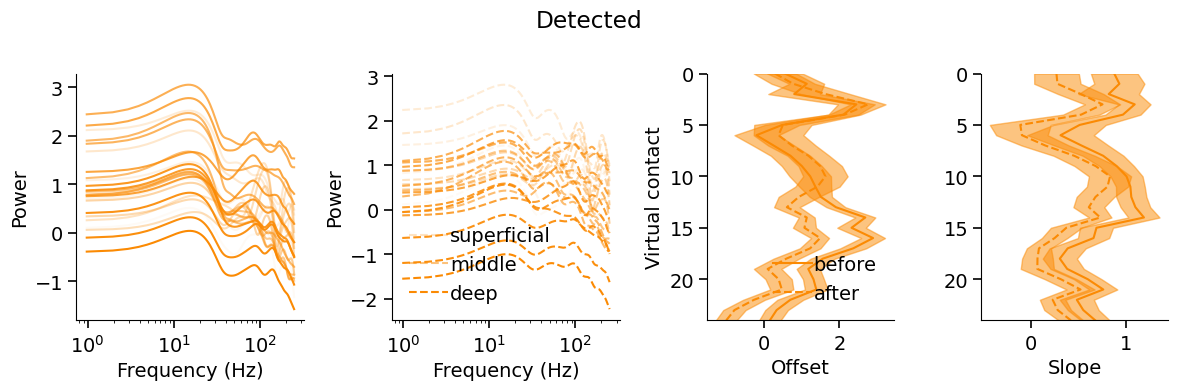

In [69]:
# Detected
# Figure
fig_ds = plt.figure(figsize = (12, 4))
fig_ds.suptitle('Detected')
gs_ds = GridSpec(1, 4, width_ratios=[.275, .275, .225, .225])
detected_color = np.array([98.4, 54.1, 1.2]) / 100

# Plot power
# detected
ax1_ds = fig_ds.add_subplot(gs_ds[0])
ax2_ds = fig_ds.add_subplot(gs_ds[1])  
plot_power(ax1_ds, mds_layer_psd_before, detected_color)  # before
plot_power(ax2_ds, mds_layer_psd_after, detected_color, linestyle='dashed')  # after
  
# Plot offset
# detected
ax3_ds = fig_ds.add_subplot(gs_ds[2])
plot_offset(ax3_ds, ds_layer_offsets_before, detected_color, 'before')  # before
plot_offset(ax3_ds, ds_layer_offsets_after, detected_color, 'after', linestyle='dashed')  # after

# Plot slope
# detected
ax4_ds = fig_ds.add_subplot(gs_ds[3])
plot_slope(ax4_ds, ds_layer_slopes_before, detected_color, 'before')  # before
plot_slope(ax4_ds, ds_layer_slopes_after, detected_color, 'after', linestyle='dashed')  # after

# Save fig
plt.tight_layout()
# fig_ds.savefig('ds.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


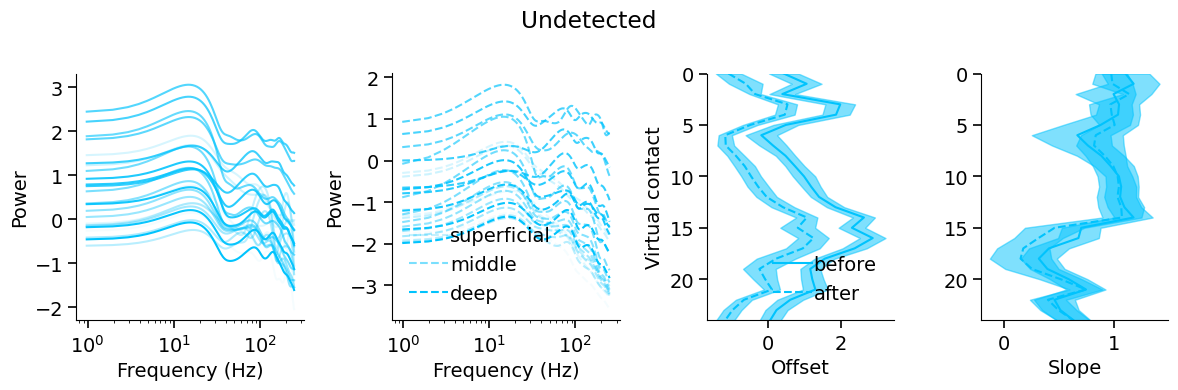

In [65]:
# Undetected
# Figure
fig_us = plt.figure(figsize=(12, 4))
fig_us.suptitle('Undetected')
gs_us = GridSpec(1, 4, width_ratios=[.275, .275, .225, .225])
undetected_color = np.array([0, 76.5, 99.2]) / 100

# Plot power
# undetected
ax1_us = fig_us.add_subplot(gs_us[0])
ax2_us = fig_us.add_subplot(gs_us[1])  
plot_power(ax1_us, mus_layer_psd_before, undetected_color)  # before
plot_power(ax2_us, mus_layer_psd_after, undetected_color, linestyle='dashed')  # after
    
# Plot offset
# undetected
ax3_us = fig_us.add_subplot(gs_us[2])
plot_offset(ax3_us, us_layer_offsets_before, undetected_color, 'before')  # before
plot_offset(ax3_us, us_layer_offsets_after, undetected_color, 'after', linestyle='dashed')  # after

# Plot slope
# undetected
ax4_us = fig_us.add_subplot(gs_us[3])
plot_slope(ax4_us, us_layer_slopes_before, undetected_color, 'before')  # before
plot_slope(ax4_us, us_layer_slopes_after, undetected_color, 'after', linestyle='dashed')  # after

# Save fig
plt.tight_layout()
#fig_us.savefig('us.png')

<Figure size 640x480 with 0 Axes>

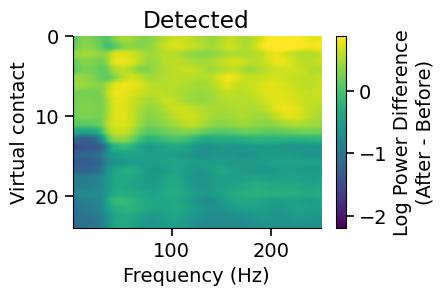

<Figure size 640x480 with 0 Axes>

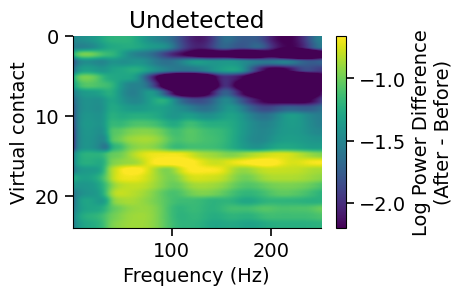

In [93]:
def plot_log_power_diff(m_layer_psd_before, m_layer_psd_after, freqs, title):
    '''Plots log power difference (After - Before).'''
    
    plt.figure()
    plt.figure(figsize=(4, 2.5))
    plt.title(title)
    
    m_before = np.log10(np.mean(m_layer_psd_before, axis=0))
    m_after = np.log10(np.mean(m_layer_psd_after, axis=0))
    im = plt.imshow(m_after - m_before, aspect='auto', extent=(freqs[0], freqs[-1], n_electrodes - 1, 0))
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Virtual contact')
    cbar = plt.colorbar(im)
    plt.clim(2, -2)
    cbar.set_label('Log Power Difference\n(After - Before)')
    
    return m_before, m_after

# detected
mds_before, mds_after = plot_log_power_diff(mds_layer_psd_before, mds_layer_psd_after, ds_freqs, 'Detected') 
# undetected
mus_before, mus_after = plot_log_power_diff(mus_layer_psd_before, mus_layer_psd_after, us_freqs, 'Undetected')  

<Figure size 640x480 with 0 Axes>

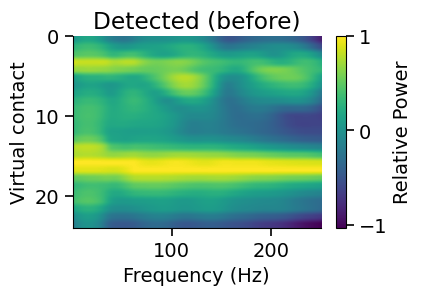

<Figure size 640x480 with 0 Axes>

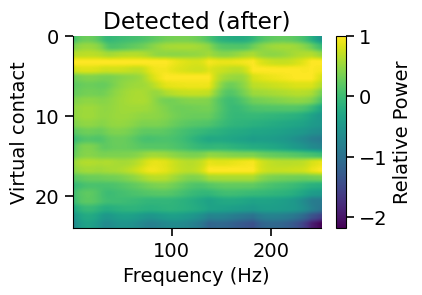

<Figure size 640x480 with 0 Axes>

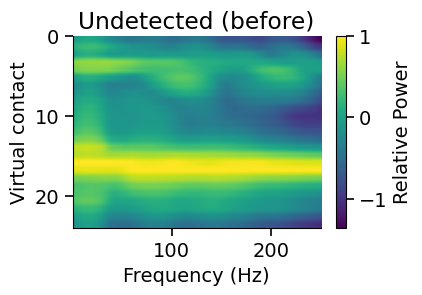

<Figure size 640x480 with 0 Axes>

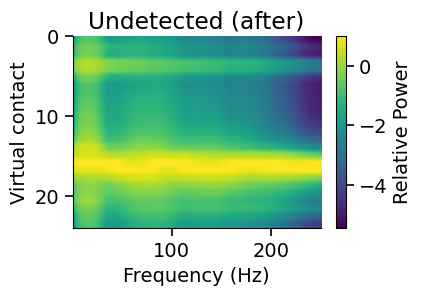

In [95]:
def plot_relative_power(m, freqs, title):
    '''Plots relative power.'''
    
    plt.figure()
    plt.figure(figsize=(4, 2.5))
    plt.title(title)
    
    rel_power = np.zeros((n_electrodes, len(freqs)))
    
    for i in range(len(freqs)):
        rel_power[:,i] = m[:,i] / np.max(m[:,i])
    im = plt.imshow(rel_power, aspect='auto', extent=(freqs[0], freqs[-1], n_electrodes - 1, 0))
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Virtual contact')
    cbar=plt.colorbar(im)
    cbar.set_label('Relative Power')
    
    return rel_power

# detected
mds_rel_power_before = plot_relative_power(mds_before, ds_freqs, 'Detected (before)')  # before
mds_rel_power_after = plot_relative_power(mds_after, ds_freqs, 'Detected (after)')  # after
# undetected
mus_rel_power_before = plot_relative_power(mus_before, us_freqs, 'Undetected (before)')  # before
mus_rel_power_after = plot_relative_power(mus_after, us_freqs, 'Undetected (after)')  # after

<Figure size 640x480 with 0 Axes>

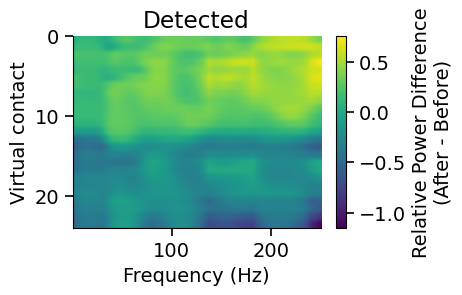

<Figure size 640x480 with 0 Axes>

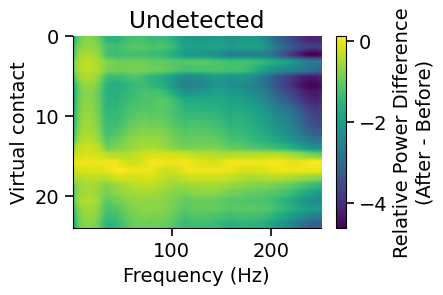

In [98]:
def plot_relative_power_diff(rel_power_before, rel_power_after, freqs, title):
    '''Plots relative power difference.'''
    
    plt.figure()
    plt.figure(figsize=(4, 2.5))
    plt.title(title)

    im = plt.imshow(rel_power_after - rel_power_before, aspect='auto', extent=(freqs[0], freqs[-1], n_electrodes - 1, 0))
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Virtual contact')
    cbar = plt.colorbar(im)
    cbar.set_label('Relative Power Difference\n(After - Before)')
    
# detected
plot_relative_power_diff(mds_rel_power_before, mds_rel_power_after, ds_freqs, 'Detected')  
# undetected
plot_relative_power_diff(mus_rel_power_before, mus_rel_power_after, us_freqs, 'Undetected')

## Compute power spectra over whole trial after subtracting out mean response, then split

In [100]:
# Compute power spectral density from STFT after subtracting mean

# detected
ds_mean = np.mean(ds_trial_signals, axis=0)
mds_layer_resid1_psd_before, mds_layer_resid1_psd_after, ds_resid1_freqs = get_psd_means(ds_trial_signals - ds_mean)
# undetected
us_mean = np.mean(us_trial_signals, axis=0)
mus_layer_resid1_psd_before, mus_layer_resid1_psd_after, us_resid1_freqs = get_psd_means(us_trial_signals - us_mean)

**Parameterize power spectra**

In [101]:
# detected 
ds_layer_resid1_offsets_before, ds_layer_resid1_slopes_before = parameterize_spectra(mds_layer_resid1_psd_before, ds_resid1_freqs)
ds_layer_resid1_offsets_after, ds_layer_resid1_slopes_after = parameterize_spectra(mds_layer_resid1_psd_after, ds_resid1_freqs)
# undetected 
us_layer_resid1_offsets_before, us_layer_resid1_slopes_before = parameterize_spectra(mus_layer_resid1_psd_before, us_resid1_freqs)
us_layer_resid1_offsets_after, us_layer_resid1_slopes_after = parameterize_spectra(mus_layer_resid1_psd_after, us_resid1_freqs)

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



**Plot spectra and parameters**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


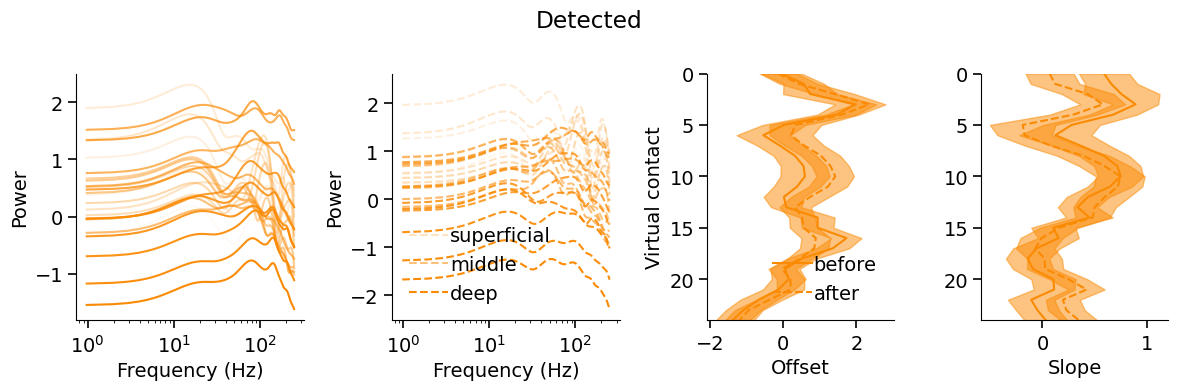

In [102]:
# Detected
# Figure
fig_resid1_ds = plt.figure(figsize=(12, 4))
fig_resid1_ds.suptitle('Detected')
gs_resid1_ds = GridSpec(1, 4, width_ratios=[.275, .275, .225, .225])

# Plot power
# detected
ax1_resid1_ds = fig_resid1_ds.add_subplot(gs_resid1_ds[0])
ax2_resid1_ds = fig_resid1_ds.add_subplot(gs_resid1_ds[1])  
plot_power(ax1_resid1_ds, mds_layer_resid1_psd_before, detected_color)  # before
plot_power(ax2_resid1_ds, mds_layer_resid1_psd_after, detected_color, linestyle='dashed')  # after
  
# Plot offset
# detected
ax3_resid1_ds = fig_resid1_ds.add_subplot(gs_resid1_ds[2])
plot_offset(ax3_resid1_ds, ds_layer_resid1_offsets_before, detected_color, 'before')  # before
plot_offset(ax3_resid1_ds, ds_layer_resid1_offsets_after, detected_color, 'after', linestyle='dashed')  # after

# Plot slope
# detected
ax4_resid1_ds = fig_resid1_ds.add_subplot(gs_resid1_ds[3])
plot_slope(ax4_resid1_ds, ds_layer_resid1_slopes_before, detected_color, 'before')  # before
plot_slope(ax4_resid1_ds, ds_layer_resid1_slopes_after, detected_color, 'after', linestyle='dashed')  # after

# Save fig
plt.tight_layout()
# fig_resid1_ds.savefig('ds_resid1.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


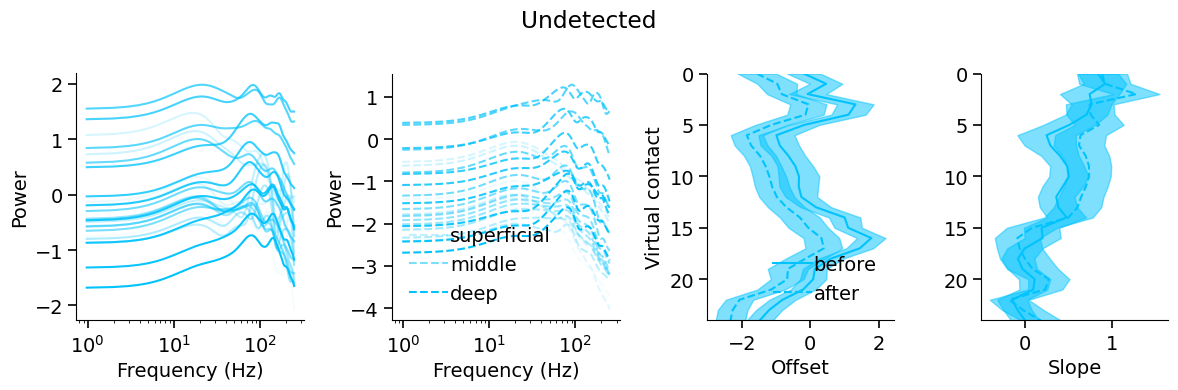

In [103]:
# Undetected
# Figure
fig_resid1_us = plt.figure(figsize=(12, 4))
fig_resid1_us.suptitle('Undetected')
gs_resid1_us = GridSpec(1, 4, width_ratios=[.275, .275, .225, .225])

# Plot power
# undetected
ax1_resid1_us = fig_resid1_us.add_subplot(gs_resid1_us[0])
ax2_resid1_us = fig_resid1_us.add_subplot(gs_resid1_us[1])  
plot_power(ax1_resid1_us, mus_layer_resid1_psd_before, undetected_color)  # before
plot_power(ax2_resid1_us, mus_layer_resid1_psd_after, undetected_color, linestyle='dashed')  # after
  
# Plot offset
# undetected
ax3_resid1_us = fig_resid1_us.add_subplot(gs_resid1_us[2])
plot_offset(ax3_resid1_us, us_layer_resid1_offsets_before, undetected_color, 'before')  # before
plot_offset(ax3_resid1_us, us_layer_resid1_offsets_after, undetected_color, 'after', linestyle='dashed')  # after

# Plot slope
# undetected
ax4_resid1_us = fig_resid1_us.add_subplot(gs_resid1_us[3])
plot_slope(ax4_resid1_us, us_layer_resid1_slopes_before, undetected_color, 'before')  # before
plot_slope(ax4_resid1_us, us_layer_resid1_slopes_after, undetected_color, 'after', linestyle='dashed')  # after

# Save fig
plt.tight_layout()
# fig_resid1_us.savefig('us_resid1.png')

<Figure size 640x480 with 0 Axes>

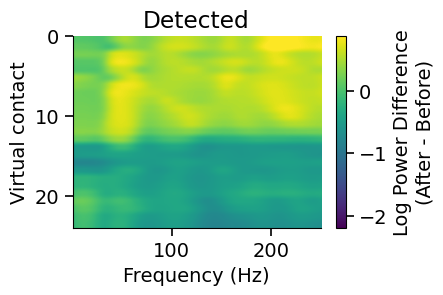

<Figure size 640x480 with 0 Axes>

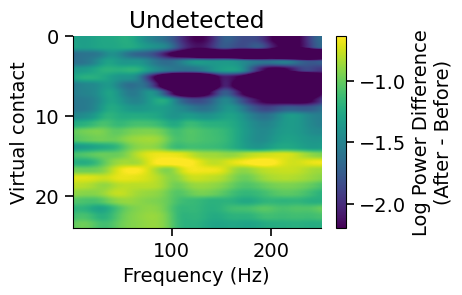

In [104]:
# Log Power Difference (After - Before) 

# detected
mds_resid1_before, mds_resid1_after = plot_log_power_diff(mds_layer_resid1_psd_before, mds_layer_resid1_psd_after, ds_resid1_freqs, 'Detected') 
# undetected
mus_resid1_before, mus_resid1_after = plot_log_power_diff(mus_layer_resid1_psd_before, mus_layer_resid1_psd_after, us_resid1_freqs, 'Undetected') 

<Figure size 640x480 with 0 Axes>

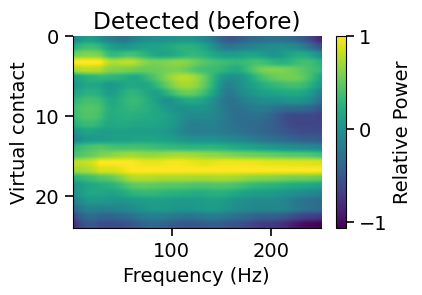

<Figure size 640x480 with 0 Axes>

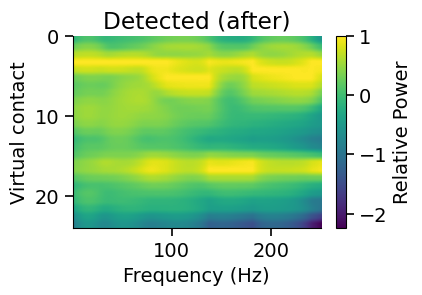

<Figure size 640x480 with 0 Axes>

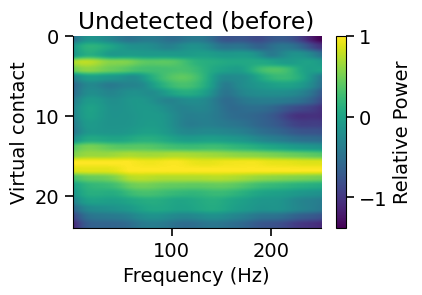

<Figure size 640x480 with 0 Axes>

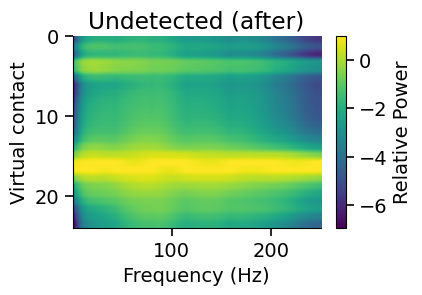

In [105]:
# Relative Power 

# detected
mds_rel_power_resid1_before = plot_relative_power(mds_resid1_before, ds_resid1_freqs, 'Detected (before)')  # before
mds_rel_power_resid1_after = plot_relative_power(mds_resid1_after, ds_resid1_freqs, 'Detected (after)')  # after
# undetected
mus_rel_power_resid1_before = plot_relative_power(mus_resid1_before, us_resid1_freqs, 'Undetected (before)')  # before
mus_rel_power_resid1_after = plot_relative_power(mus_resid1_after, us_resid1_freqs, 'Undetected (after)')  # after

<Figure size 640x480 with 0 Axes>

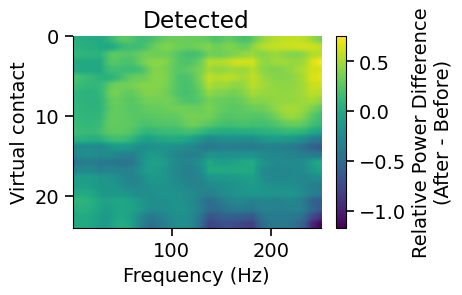

<Figure size 640x480 with 0 Axes>

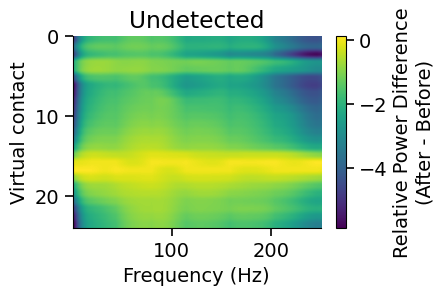

In [106]:
# Relative Power Diff

# detected
plot_relative_power_diff(mds_rel_power_resid1_before, mds_rel_power_resid1_after, ds_resid1_freqs, 'Detected')  
# undetected
plot_relative_power_diff(mus_rel_power_resid1_before, mus_rel_power_resid1_after, us_resid1_freqs, 'Undetected')

## Compute power spectra over whole trial after regressing out mean response

In [107]:
# Regression

# detected
ds_trial_resids = np.zeros(ds_trial_signals.shape)  
for t_idx in range(n_trials):
    for e_idx in range(n_electrodes):
        # Regress out ERF
        slope, intercept, r, p, se = linregress(ds_mean[e_idx,:], ds_trial_signals[t_idx, e_idx, :])
        ds_trial_resids[t_idx,e_idx,:] = ds_trial_signals[t_idx, e_idx, :] - (intercept + slope * ds_mean[e_idx,:])
# undetected
us_trial_resids = np.zeros(us_trial_signals.shape)  
for t_idx in range(n_trials):
    for e_idx in range(n_electrodes):
        # Regress out ERF
        slope, intercept, r, p, se = linregress(us_mean[e_idx,:], us_trial_signals[t_idx, e_idx, :])
        us_trial_resids[t_idx,e_idx,:] = us_trial_signals[t_idx, e_idx, :] - (intercept + slope * us_mean[e_idx,:])
        
# Compute power spectral density from STFT after regressing out mean

# detected
mds_layer_resid2_psd_before, mds_layer_resid2_psd_after, ds_resid2_freqs = get_psd_means(ds_trial_resids)
# undetected
mus_layer_resid2_psd_before, mus_layer_resid2_psd_after, us_resid2_freqs = get_psd_means(us_trial_resids)

**Parameterize power spectra**

In [108]:
# detected 
ds_layer_resid2_offsets_before, ds_layer_resid2_slopes_before = parameterize_spectra(mds_layer_resid2_psd_before, ds_resid2_freqs)
ds_layer_resid2_offsets_after, ds_layer_resid2_slopes_after = parameterize_spectra(mds_layer_resid2_psd_after, ds_resid2_freqs)
# undetected 
us_layer_resid2_offsets_before, us_layer_resid2_slopes_before = parameterize_spectra(mus_layer_resid2_psd_before, us_resid2_freqs)
us_layer_resid2_offsets_after, us_layer_resid2_slopes_after = parameterize_spectra(mus_layer_resid2_psd_after, us_resid2_freqs)

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



**Plot spectra and parameters**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


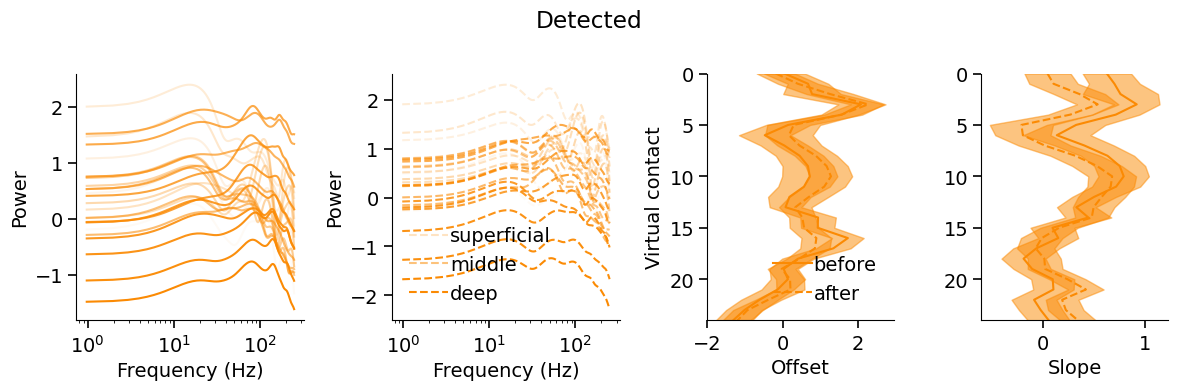

In [109]:
# Detected
# Figure
fig_resid2_ds = plt.figure(figsize=(12, 4))
fig_resid2_ds.suptitle('Detected')
gs_resid2_ds = GridSpec(1, 4, width_ratios=[.275, .275, .225, .225])

# Plot power
# detected
ax1_resid2_ds = fig_resid2_ds.add_subplot(gs_resid2_ds[0])
ax2_resid2_ds = fig_resid2_ds.add_subplot(gs_resid2_ds[1])  
plot_power(ax1_resid2_ds, mds_layer_resid2_psd_before, detected_color)  # before
plot_power(ax2_resid2_ds, mds_layer_resid2_psd_after, detected_color, linestyle='dashed')  # after
  
# Plot offset
# detected
ax3_resid2_ds = fig_resid2_ds.add_subplot(gs_resid2_ds[2])
plot_offset(ax3_resid2_ds, ds_layer_resid2_offsets_before, detected_color, 'before')  # before
plot_offset(ax3_resid2_ds, ds_layer_resid2_offsets_after, detected_color, 'after', linestyle='dashed')  # after

# Plot slope
# detected
ax4_resid2_ds = fig_resid2_ds.add_subplot(gs_resid2_ds[3])
plot_slope(ax4_resid2_ds, ds_layer_resid2_slopes_before, detected_color, 'before')  # before
plot_slope(ax4_resid2_ds, ds_layer_resid2_slopes_after, detected_color, 'after', linestyle='dashed')  # after

# Save fig
plt.tight_layout()
# fig_resid2_ds.savefig('ds_resid2.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


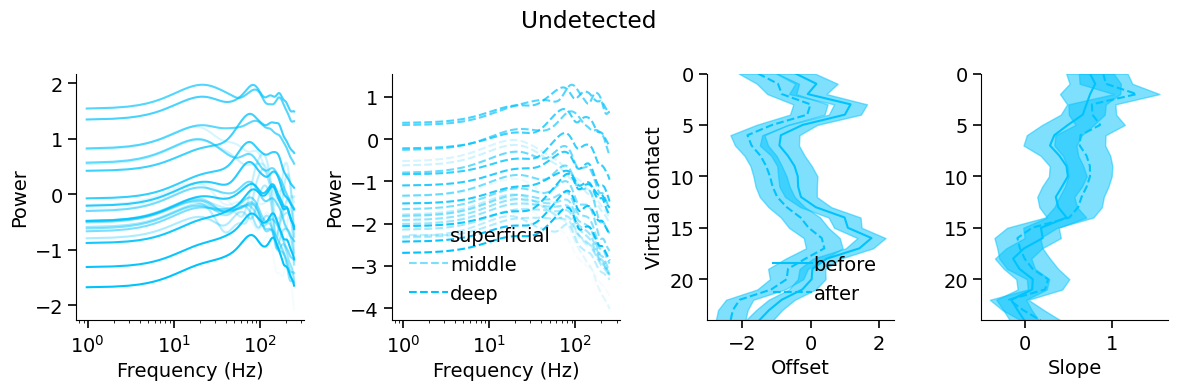

In [110]:
# Undetected
# Figure
fig_resid2_us = plt.figure(figsize=(12, 4))
fig_resid2_us.suptitle('Undetected')
gs_resid2_us = GridSpec(1, 4, width_ratios=[.275, .275, .225, .225])

# Plot power
# undetected
ax1_resid2_us = fig_resid2_us.add_subplot(gs_resid2_us[0])
ax2_resid2_us = fig_resid2_us.add_subplot(gs_resid2_us[1])  
plot_power(ax1_resid2_us, mus_layer_resid2_psd_before, undetected_color)  # before
plot_power(ax2_resid2_us, mus_layer_resid2_psd_after, undetected_color, linestyle='dashed')  # after
  
# Plot offset
# undetected
ax3_resid2_us = fig_resid2_us.add_subplot(gs_resid2_us[2])
plot_offset(ax3_resid2_us, us_layer_resid2_offsets_before, undetected_color, 'before')  # before
plot_offset(ax3_resid2_us, us_layer_resid2_offsets_after, undetected_color, 'after', linestyle='dashed')  # after

# Plot slope
# undetected
ax4_resid2_us = fig_resid2_us.add_subplot(gs_resid2_us[3])
plot_slope(ax4_resid2_us, us_layer_resid2_slopes_before, undetected_color, 'before')  # before
plot_slope(ax4_resid2_us, us_layer_resid2_slopes_after, undetected_color, 'after', linestyle='dashed')  # after

# Save fig
plt.tight_layout()
# fig_resid2_us.savefig('us_resid2.png')

<Figure size 640x480 with 0 Axes>

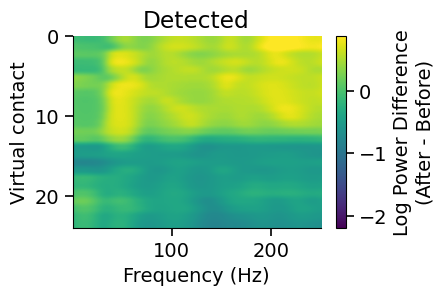

<Figure size 640x480 with 0 Axes>

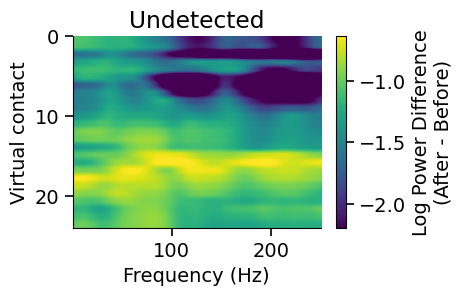

In [111]:
# Log Power Difference (After - Before) 

# detected
mds_resid2_before, mds_resid2_after = plot_log_power_diff(mds_layer_resid2_psd_before, mds_layer_resid2_psd_after, ds_resid2_freqs, 'Detected') 
# undetected
mus_resid2_before, mus_resid2_after = plot_log_power_diff(mus_layer_resid2_psd_before, mus_layer_resid2_psd_after, us_resid2_freqs, 'Undetected') 

<Figure size 640x480 with 0 Axes>

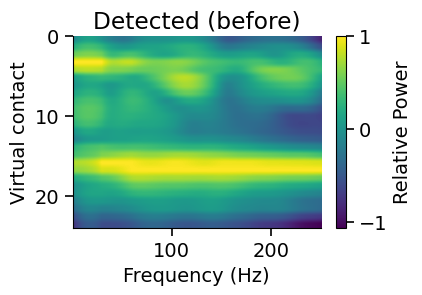

<Figure size 640x480 with 0 Axes>

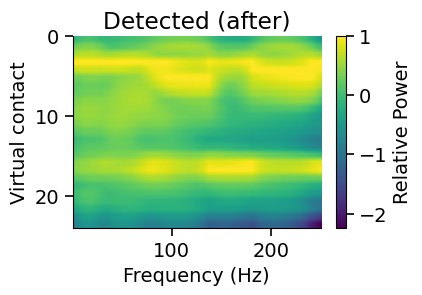

<Figure size 640x480 with 0 Axes>

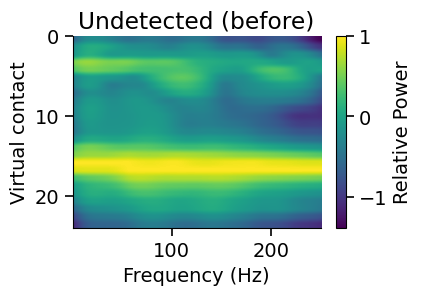

<Figure size 640x480 with 0 Axes>

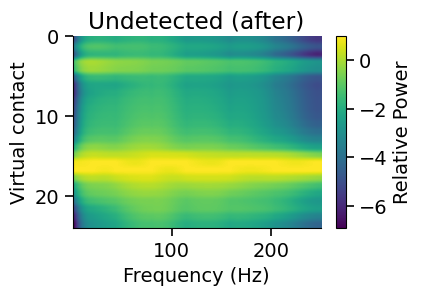

In [112]:
# Relative Power 

# detected
mds_rel_power_resid2_before = plot_relative_power(mds_resid2_before, ds_resid2_freqs, 'Detected (before)')  # before
mds_rel_power_resid2_after = plot_relative_power(mds_resid2_after, ds_resid2_freqs, 'Detected (after)')  # after
# undetected
mus_rel_power_resid2_before = plot_relative_power(mus_resid2_before, us_resid2_freqs, 'Undetected (before)')  # before
mus_rel_power_resid2_after = plot_relative_power(mus_resid2_after, us_resid2_freqs, 'Undetected (after)')  # after

<Figure size 640x480 with 0 Axes>

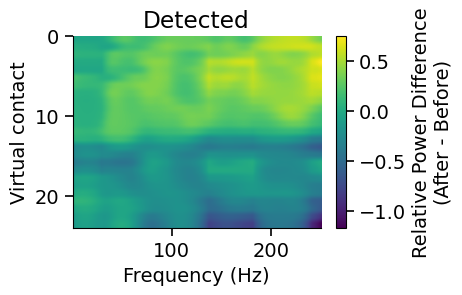

<Figure size 640x480 with 0 Axes>

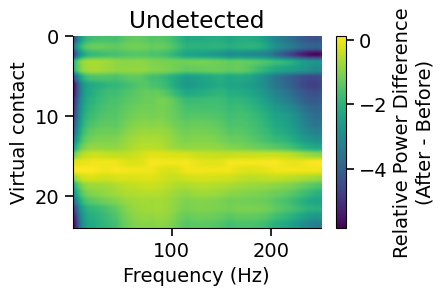

In [113]:
# Relative Power Diff

# detected
plot_relative_power_diff(mds_rel_power_resid2_before, mds_rel_power_resid2_after, ds_resid2_freqs, 'Detected')  
# undetected
plot_relative_power_diff(mus_rel_power_resid2_before, mus_rel_power_resid2_after, us_resid2_freqs, 'Undetected')